# MultiLabel Logistic Regression using Tensorflow Core

- Multi-label classification is a type of classification problem in machine learning where each instance (data sample) can belong to multiple classes or have multiple labels. 
- In traditional single-label classification, each instance is associated with a single label, and the goal is to predict the most appropriate label for each instance. However, in multi-label classification, instances can be associated with more than one label simultaneously.

- **Single-label classification:**
> Suppose you have an image classification problem to identify animals in images. Each image contains only one animal, and you want to classify the image into one of the animal categories (e.g., cat, dog, bird).
- **Multi-label Classification:**
> Now, let's consider a multi-label classification scenario. Instead of single animals per image, each image can contain multiple animals, and you want to predict all the animals present in the image (e.g., cat, dog, bird, fish).

There are multiple approaches to solve multi-label classification problem such as **Binary Relevance**, **Classifier Chains**, **Label Powerset**, **neural network with multiple output and binary loss function**

- We are going to implement logistic regression (or single layer perceptrons with n_labels outputs and binary loss function

## Difference between multi-class classification and multi-label classification

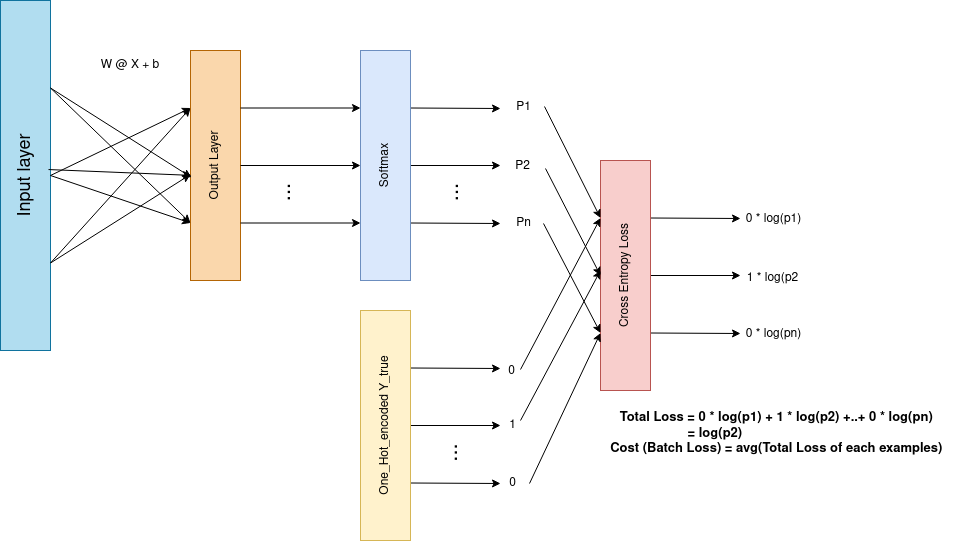
<p style="text-align: center;"><b>Figure: Multi-class classification forward pass</b></p>

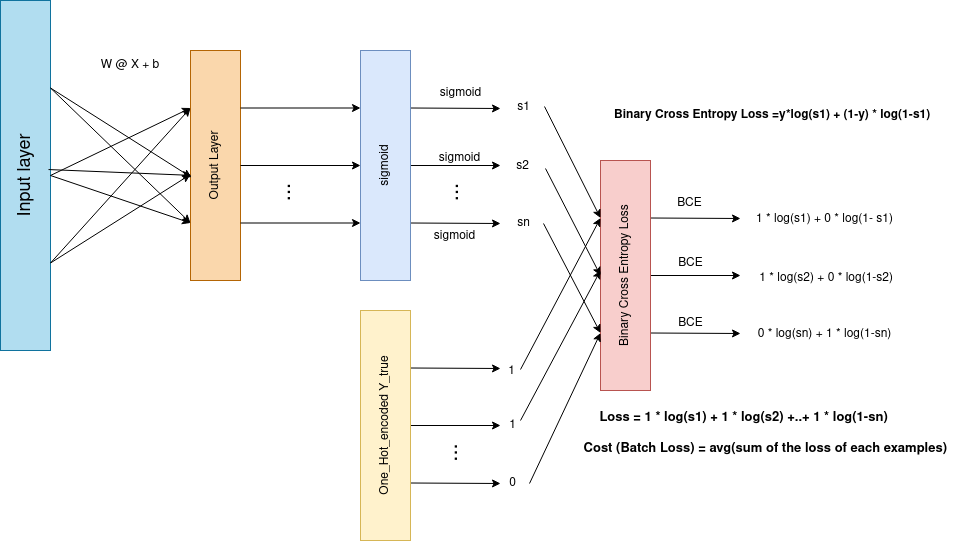
<p style="text-align: center;"><b>Figure: Multi-label classification forward pass</b></p>

# Dataset
- This time we are going to solve nlp problem to demonstrate multi-label logistic regression.
- **Name of the dataset:** Question from cross Validation stack exchange
- **URL**: https://www.kaggle.com/datasets/stackoverflow/statsquestions
- **API to download the dataset**: kaggle datasets download -d stackoverflow/statsquestions
- **problem statement**: classify the question into multiple tags, one question may belongs to zero, one or more than one tags.

Before downloading the dataset from kaggle we have to do some setups:
- install kaggle
```
pip install kaggle -q

```
- download kaggle.json file from your kaggle account, we need that for authentication.

In [ ]:
# pip install kaggle -q

In [2]:
# I have already downloaded the kaggle.json file
! cd ../../ && ls

'architecture implementations'	 LICENSE
 daily_logs.md			 README.md
 kaggle.json			'tensorflow from basic to advance'
'keras basic to advance'


There you can see kaggle.json file

In [3]:
# specify the path to the kaggle.json file
import os

os.environ["KAGGLE_CONFIG_DIR"] = "../../"

In [4]:
# Now we can download file using the API
!kaggle datasets download -d stackoverflow/statsquestions

statsquestions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls

'Binary Logistic Regression with Tensorflow core.ipynb'
 dataset
'Multiclass Logistic Regression with tensorfow core.ipynb'
'Multilabel Classification.ipynb'
'MultiLabel Logistic Regression using Tensorflow core.ipynb'
 statsquestions.zip
'Vanishing Gradient problem.ipynb'
'with Tensorflow core.ipynb'


There you can see statsquestions.zip file which is our dataset. Now let's unzip it.

In [ ]:
import shutil

zip_file_path = "statsquestions.zip"
destination_directory = "dataset"
shutil.unpack_archive(zip_file_path, destination_directory, 'zip')

In [ ]:
!ls dataset

We have our dataset ready, let's do some exploratory data analysis.

# EDA
Exploratory Data Analysis (EDA) is an essential step in the data analysis process, where analysts or data scientists examine and summarize the main characteristics of a dataset to gain insights and understand the data better. 

In [86]:
# !pip install seaborn -q

In [320]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [203]:
df_questions = pd.read_csv("dataset/Questions.csv", encoding='iso-8859-1')
df_tags = pd.read_csv("dataset/Tags.csv", encoding='iso-8859-1')

In [204]:
df_questions.shape, df_tags.shape

((85085, 6), (244228, 2))

So we have about 85K questions and 244k tags. Don't get surprised for having more tags than questions, one question can have more that one tag remember?.

In [205]:
df_questions.head()

,Id,OwnerUserId,CreationDate,Score,Title,Body
0,6,5.0,2010-07-19T19:14:44Z,272,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,59.0,2010-07-19T19:24:36Z,4,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,66.0,2010-07-19T19:25:39Z,208,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,13.0,2010-07-19T19:28:44Z,138,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,8.0,2010-07-19T19:31:47Z,58,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."


OwnerUerID, CreatinData and score are unwanted columns, we can remove them.

In [206]:
df_tags.head()

,Id,Tag
0,1,bayesian
1,1,prior
2,1,elicitation
3,2,distributions
4,2,normality


Here, question_id 1 has tags bayesian, prior, and elicitation. 
Let's check our the frequencies of these tags.

In [207]:
len(df_tags.Tag.value_counts())

1315

We have 1315 unique tags in our dataset.

In [208]:
df_tags.Tag.value_counts().head(10)

Tag
r                     13236
regression            10959
machine-learning       6089
time-series            5559
probability            4217
hypothesis-testing     3869
self-study             3732
distributions          3501
logistic               3316
classification         2881
Name: count, dtype: int64

It seems tag "r" has the highest frequency i.e more than 13K, we are only looking at the top 10 tags.

In [209]:
df_tags.Tag.value_counts().sample(10)

Tag
invariance                  12
polynomial                 154
confounding                106
variogram                   52
lifetable                    7
artificial-intelligence     72
hidden-markov-model        314
excel                      257
word-embeddings             44
covariate                  104
Name: count, dtype: int64

Upon checking frequency of the random tags, we are clear that some tags have very few presence in the dataset. Thus, we cannot use those tags model training. Let's take only the top 100 tags, and we will make a model to classify question to these most frequent 100 tags.

# Taking only the top 100 frequent tags

In [210]:
NUM_LABELS= 100

In [211]:
grouped_tags = df_tags.groupby("Tag").size().reset_index(name='count')
most_common_tags = grouped_tags.nlargest(NUM_LABELS, columns="count")

In [212]:
len(most_common_tags)

100

In [213]:
most_common_tags

,Tag,count
986,r,13236
1020,regression,10959
669,machine-learning,6089
1220,time-series,5559
946,probability,4217
...,...,...
818,nonlinear-regression,514
240,cox-model,510
757,monte-carlo,504
959,proportion,503


In [214]:
MOST_COMMON_TAGS = list(set(most_common_tags.Tag.to_list()))
", ".join(MOST_COMMON_TAGS)

'cox-model, regression, t-test, terminology, mixed-model, optimization, categorical-data, repeated-measures, data-transformation, r, autocorrelation, multivariate-analysis, binomial, stata, standard-error, hypothesis-testing, interaction, random-variable, model, interpretation, matlab, data-mining, missing-data, expected-value, arima, random-forest, mean, estimation, multiple-comparisons, experiment-design, econometrics, bayesian, nonparametric, neural-networks, statistical-significance, cross-validation, sample-size, maximum-likelihood, data-visualization, confidence-interval, probability, pca, predictive-models, multilevel-analysis, simulation, deep-learning, multiple-regression, covariance, svm, chi-squared, random-effects-model, distributions, python, linear-model, standard-deviation, outliers, cart, algorithms, stochastic-processes, nonlinear-regression, regression-coefficients, logistic, monte-carlo, proportion, model-selection, time-series, binary-data, references, bootstrap, le

In [215]:
len(MOST_COMMON_TAGS)

100

Now, let's remove tags which are not common

In [216]:
df_tags.Tag = df_tags.Tag.apply(lambda tag: tag if tag in MOST_COMMON_TAGS else None)

In [217]:
df_tags.Tag

0                        bayesian
1                            None
2                            None
3                   distributions
4                            None
                   ...           
244223           machine-learning
244224    mathematical-statistics
244225        normal-distribution
244226                 estimation
244227                       None
Name: Tag, Length: 244228, dtype: object

We have replace less common tags with None values, so that we can remove it using dropna()

In [218]:
df_tags.dropna(inplace=True, ignore_index=True)

In [219]:
df_tags.Tag

0                         bayesian
1                    distributions
2                    distributions
3         statistical-significance
4                 machine-learning
                    ...           
152908                           r
152909            machine-learning
152910     mathematical-statistics
152911         normal-distribution
152912                  estimation
Name: Tag, Length: 152913, dtype: object

We have successfully remove less common tags from the tag dataframe.

# Text Preprocessing

In [220]:
df_questions = df_questions[['Id', 'Title', 'Body']]
df_questions.head()

,Id,Title,Body
0,6,The Two Cultures: statistics vs. machine learn...,"<p>Last year, I read a blog post from <a href=..."
1,21,Forecasting demographic census,<p>What are some of the ways to forecast demog...
2,22,Bayesian and frequentist reasoning in plain En...,<p>How would you describe in plain English the...
3,31,What is the meaning of p values and t values i...,<p>After taking a statistics course and then t...
4,36,Examples for teaching: Correlation does not me...,"<p>There is an old saying: ""Correlation does n..."


You can see **Body** column contains text along with HTML tags, let's clean that up. We can use regex for this.

In [221]:
import re

# specify pattern for HTML tags
#  .*? is a non-greedy quantifier that matches zero or more occurrences of any character (except for a newline) 
# in a non-greedy or minimal fashion. 
# This means it will match as few characters as possible while still allowing the overall pattern to match.
HTML_TAG_PATTERN = "<.*?>"
test_text = "<HTML><a href='example.com'>click me</a></HTML>"

re.sub(HTML_TAG_PATTERN, "", test_text)

'click me'

You can see \<HTML> and \<a> tags got removed from the text. Now, let's put this into a function.

In [222]:
def clean_text(text):
    HTML_TAG_PATTERN = "<.*?>"
    clean_text = re.sub(HTML_TAG_PATTERN, "", text).lower()
    # we are also ignoring punctuation marks except ' from the text 
    return " ".join(re.sub(r"[^a-zA-Z0-9 ']", ' ', clean_text).split())

In [223]:
df_questions.iloc[0].Body

'<p>Last year, I read a blog post from <a href="http://anyall.org/">Brendan O\'Connor</a> entitled <a href="http://anyall.org/blog/2008/12/statistics-vs-machine-learning-fight/">"Statistics vs. Machine Learning, fight!"</a> that discussed some of the differences between the two fields.  <a href="http://andrewgelman.com/2008/12/machine_learnin/">Andrew Gelman responded favorably to this</a>:</p>\n\n<p>Simon Blomberg: </p>\n\n<blockquote>\n  <p>From R\'s fortunes\n  package: To paraphrase provocatively,\n  \'machine learning is statistics minus\n  any checking of models and\n  assumptions\'.\n  -- Brian D. Ripley (about the difference between machine learning\n  and statistics) useR! 2004, Vienna\n  (May 2004) :-) Season\'s Greetings!</p>\n</blockquote>\n\n<p>Andrew Gelman:</p>\n\n<blockquote>\n  <p>In that case, maybe we should get rid\n  of checking of models and assumptions\n  more often. Then maybe we\'d be able to\n  solve some of the problems that the\n  machine learning people can

In [224]:
# checking if the function is working as expected or not
clean_text(df_questions.iloc[0].Body)

"last year i read a blog post from brendan o'connor entitled statistics vs machine learning fight that discussed some of the differences between the two fields andrew gelman responded favorably to this simon blomberg from r's fortunes package to paraphrase provocatively 'machine learning is statistics minus any checking of models and assumptions' brian d ripley about the difference between machine learning and statistics user 2004 vienna may 2004 season's greetings andrew gelman in that case maybe we should get rid of checking of models and assumptions more often then maybe we'd be able to solve some of the problems that the machine learning people can solve but we can't there was also the statistical modeling the two cultures paper by leo breiman in 2001 which argued that statisticians rely too heavily on data modeling and that machine learning techniques are making progress by instead relying on the predictive accuracy of models has the statistics field changed over the last decade i

It seems it is working fine. Let's apply it to the entire dataset.

In [225]:
df_questions["Body"] = df_questions.Body.apply(clean_text)
# New column Text contains input text for the model
df_questions["Text"] = df_questions.Title.apply(clean_text)+ ' ' + df_questions["Body"]

In [226]:
df_questions.Text[0]

"the two cultures statistics vs machine learning last year i read a blog post from brendan o'connor entitled statistics vs machine learning fight that discussed some of the differences between the two fields andrew gelman responded favorably to this simon blomberg from r's fortunes package to paraphrase provocatively 'machine learning is statistics minus any checking of models and assumptions' brian d ripley about the difference between machine learning and statistics user 2004 vienna may 2004 season's greetings andrew gelman in that case maybe we should get rid of checking of models and assumptions more often then maybe we'd be able to solve some of the problems that the machine learning people can solve but we can't there was also the statistical modeling the two cultures paper by leo breiman in 2001 which argued that statisticians rely too heavily on data modeling and that machine learning techniques are making progress by instead relying on the predictive accuracy of models has the

# Merge Two dataframe
- Now let's merge two dataframe. 
- To merge two dataframe, we will store list of tags that belong to a particular question into a separete column.

In [227]:
# we can get all the tags from tag dataframe based on question id
df_tags[df_tags["Id"] == 25].Tag.values

array(['modeling', 'time-series'], dtype=object)

So, we have two tags that belongs to id == 25.

In [228]:
# since we have removed most of the tags we might get empty list also for a particular id.
df_tags[df_tags["Id"] == 20].Tag.values

array([], dtype=object)

In [229]:
def extract_tags_by_id(q_id):
    return df_tags[df_tags["Id"] == q_id].Tag.values

# this will add the list of tags of a particular id into a new column Tags.
def add_tags_row(row):
    row["Tags"] = extract_tags_by_id(row["Id"])
    return row

In [230]:
df_questions = df_questions.apply(add_tags_row, axis=1)

In [231]:
df_questions.head()[["Id", "Text", "Tags"]]

,Id,Text,Tags
0,6,the two cultures statistics vs machine learnin...,[machine-learning]
1,21,forecasting demographic census what are some o...,[forecasting]
2,22,bayesian and frequentist reasoning in plain en...,[bayesian]
3,31,what is the meaning of p values and t values i...,"[hypothesis-testing, t-test, p-value, interpre..."
4,36,examples for teaching correlation does not mea...,[correlation]


Our final dataframe is ready, now we need to tokenize and prepare the input x and y.

Before that let's analyze the tag distribution
- **What is the max and min number of tags assigned to a single question?**
- **what is the frequenty of number of tags assigned to each question?**
- **Count of each tag in the entire dataset to check how imbalanced is the dataset ?**

In [321]:
# we prepare a list that contains the length of tags for each question
tags_count = [len(tags) for tags in df_questions.Tags.values] 
tags_count[:10]

[1, 1, 1, 4, 1, 2, 1, 2, 1, 1]

In [322]:
# lets view its statistics
tags_count_series = pd.Series(tags_count)
tags_count_series.describe()

count    85085.000000
mean         1.797179
std          1.099932
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
dtype: float64

So, the maximum number of tags assigned to a question is 5. (No question is assigned with more that 5 tags). Similarly, we can see mean, std and up 75% tags are of length 2. We can say that tag distribution is right skewed.

<Axes: ylabel='Frequency'>

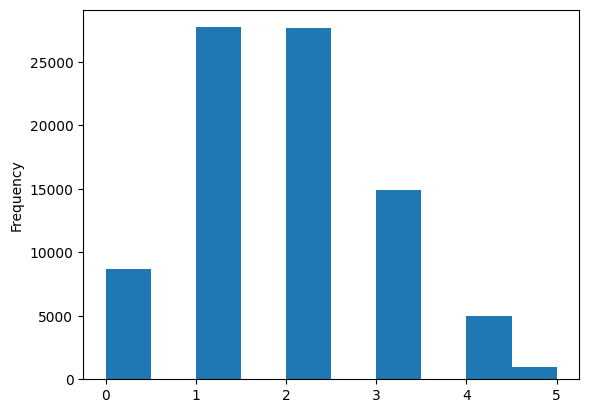

In [323]:
# let's view the histogram
tags_count_series.plot(kind="hist")

As I mentioned earlier, it is right skewed.
Here we can see
- tags of length 1 and 2 are over 25k. Majority of question in dataset have 2 tags.
- tags of length 4 and 5 are below 5k.

We can conclude that our dataset is highly imbalanced. 

# Vectorization
- Vectorization in NLP refers to the process of converting text data into numerical vectors that machine learning algorithms can understand and process.
- We need to vectorize the text as well as Tags.
- This time we are using tensorflow built-in functions, we can create our custom functions also to do the same tast and it is not that complex. When we start focusing on text preprocessing that time we are going to implement these functions from scratch.

In [235]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer

- MultilableBinarizer helps to vectorize the list of labels into one hot encoding
- For instance, let's say we have 3 unique labels, and example belongs to label 1 and label 2 than its one hot encoding will be [1 1 0] 

In [236]:
multi_label_binarizer = MultiLabelBinarizer()
multi_label_binarizer.fit(df_questions.Tags)

MultiLabelBinarizer()

In [237]:
LABELS = multi_label_binarizer.classes_
# this should be equals to NUM_LABELS == 100
len(LABELS)

100

In [238]:
LABELS

array(['algorithms', 'anova', 'arima', 'autocorrelation', 'bayesian',
       'binary-data', 'binomial', 'bootstrap', 'cart', 'categorical-data',
       'chi-squared', 'classification', 'clustering',
       'conditional-probability', 'confidence-interval', 'correlation',
       'covariance', 'cox-model', 'cross-validation', 'data-mining',
       'data-transformation', 'data-visualization', 'dataset',
       'deep-learning', 'distributions', 'econometrics', 'estimation',
       'expected-value', 'experiment-design', 'factor-analysis',
       'feature-selection', 'forecasting', 'generalized-linear-model',
       'goodness-of-fit', 'hypothesis-testing', 'inference',
       'interaction', 'interpretation', 'least-squares', 'linear-model',
       'logistic', 'machine-learning', 'mathematical-statistics',
       'matlab', 'maximum-likelihood', 'mcmc', 'mean', 'missing-data',
       'mixed-model', 'model', 'model-selection', 'modeling',
       'monte-carlo', 'multilevel-analysis', 'multiple-co

Now, let's create a text tokenizer, and transform the text into sequences along with padding
- This basically involves three tasks
    - transform raw text into sequence of tokens
    - transform seq of tokens into sequence of integer values (replace token by its corresponding index)
    - all padding or remove exceeding elements from sequence to make all the examples into same sequence length
- To perform mentioned task we can use Tokenizer and pad_sequences class

In [239]:
MAX_LEN = 180
VOCAB_SIZE = 1000

tokenizer = Tokenizer(num_words=VOCAB_SIZE, lower=True)
tokenizer.fit_on_texts(df_questions.Text)

In [240]:
def text_to_feature_vector(corpus):
    sequences = tokenizer.texts_to_sequences(corpus)
    return pad_sequences(sequences, MAX_LEN)

In [241]:
text_to_feature_vector([df_questions.Text.values[10]])

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 243, 339,   5, 220,  66,   3, 387, 243, 962,   9,  66,
        680, 267,  68,  78, 339, 297,  11,   3, 311,  83,   5,  78,  12,
          2,  95,   4, 164, 768, 646, 726, 191, 230, 598,  94, 643,   9,
        134,   2,  18,  63, 629,  38,  49,  73,   2,  49,  90, 393,  67,
          9,  67, 556, 268,  46,  24,  84,  21, 654,   2, 111, 632,  22,
        550, 974,  32,  20, 104,   4,  21,   3, 636

Let's create a function that transform the model predictions into {label : prob} dictionary

In [242]:
def prediction_to_label(preds):
    label_prob = [(LABELS[i], prob) for i, prob in enumerate(preds.numpy().tolist()[0])]
    return dict(sorted(label_prob, key=lambda kv:kv[1], reverse=True))

In [243]:
# Testing prediction_to_label class
dummy_preds = tf.random.uniform([1, 10])
dummy_preds

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.57616186, 0.8954301 , 0.9217074 , 0.5903969 , 0.9786967 ,
        0.62122273, 0.10471392, 0.8252176 , 0.0065608 , 0.22762573]],
      dtype=float32)>

In [244]:
prediction_to_label(dummy_preds)

{'bayesian': 0.9786967039108276,
 'arima': 0.9217073917388916,
 'anova': 0.8954300880432129,
 'bootstrap': 0.825217604637146,
 'binary-data': 0.621222734451294,
 'autocorrelation': 0.5903968811035156,
 'algorithms': 0.5761618614196777,
 'categorical-data': 0.22762572765350342,
 'binomial': 0.10471391677856445,
 'cart': 0.006560802459716797}

# Prepare Input data

In [326]:
# here we are dividing feature vector by VOCAB_SIZE for normalization, 
# In practice, use of EmbeddingMatrix is more common, it tends to improve performance.
x = text_to_feature_vector(df_questions.Text) / VOCAB_SIZE
y = multi_label_binarizer.transform(df_questions.Tags)

Now we have binarized our tags, which means
- let's say we have labels **{a,b,c,d,e}** and a question has tag **[a, b, d]** then its binarization transformation will be
**[1, 1, 0, 1]** (just a one-hot encoding)

In [325]:
# let's seet first two rows(questions) and only the first 20 tags one-hot encoding our of 100.
y[:2, :20]

<tf.Tensor: shape=(2, 20), dtype=int64, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])>

Now, we have one-hot encoded tags, we can visualize the frequency of each tags in our entire dataset.
- We can simply sum the y matrix by axis=0, each column gives the frequency of the corresponding tags.

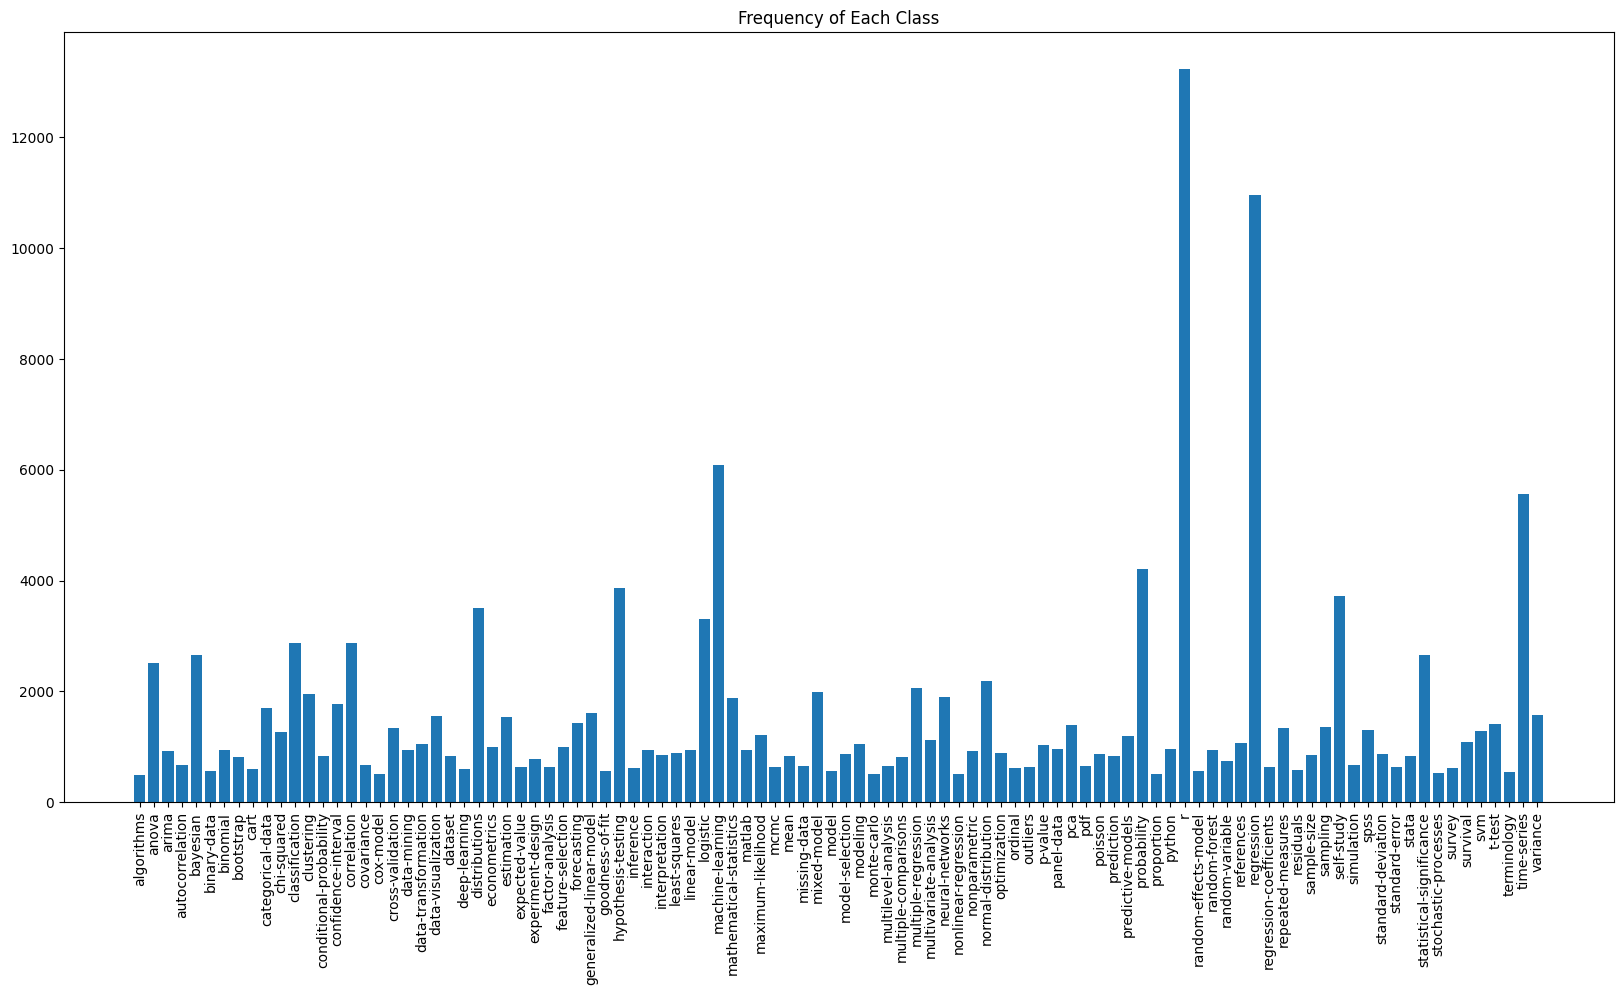

In [327]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.bar(x=LABELS, height=tf.math.reduce_sum(y, axis=0))
plt.title("Frequency of Each Class")
plt.show()

We can interpret this histogram as 
- tag "r" has high number of occurance
- If we discard these highly occuring tags, other tags seems uniformly distributed.
- Overall we can say the our dataset is imbalanced.

**⚠️ Initially we are ignoring the fact that the dataset is imbalanced and do nothing to handle this imabanced situation. Just to see how the model performs in this situation.**

In [247]:
x.shape, y.shape

((85085, 180), (85085, 100))

In [248]:
from sklearn.model_selection import train_test_split

Let's split our dataset into train test, however we are not going to test the model with test dataset.
We will try to check the model sanity by overfitting it. It will help us to understand whether our model is working fine and can learn. 

**⚠️ Since it is an nlp task and we are just using logistic regression, it is almost certain that our model won't have high accuracy. We will focus on improving model performance when we are doing projects.** 

In [328]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [329]:
x_train.shape, y_train.shape, x_test.shape

((59559, 180), (59559, 100), (25526, 180))

- Here you can see, x_train is of shape 85K x 180 matrix, where 85k represents rows(number of examples) and each row is encoded with vector of dim 180.
- similarly, y_train is of shape 85K x 100, where 85k represents rows and each row is encoded with vector of dim 100.

In [330]:
x_train[0]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.079, 0.103, 0.001, 0.558, 0.001, 0.106, 0.303,
       0.221, 0.075, 0.01 , 0.001, 0.077, 0.252, 0.191, 0.23 , 0.793,
       0.003, 0.08 , 0.027, 0.002, 0.175, 0.063, 0.558, 0.033, 0.002,
       0.315, 0.05 , 0.07 , 0.009, 0.352, 0.001, 0.106, 0.558, 0.001,
       0.301, 0.007, 0.597, 0.616, 0.011, 0.11 , 0.558, 0.059, 0.013,
       0.028, 0.047, 0.558, 0.059, 0.028, 0.047, 0.042, 0.032, 0.038,
       0.002, 0.082, 0.007, 0.701, 0.073, 0.315, 0.088, 0.075, 0.528,
       0.038, 0.049,

In [331]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

- Previously we used batch gradient descent optimization technique, where entire dataset is taken as a single batch.
- This time we are going to use mini batch gradient descent optimization technique, where we divide the entire dataset into multiple batches. We use each batch at a time for loss calculation and weight adjustment (simply model training).
- We can use **tf.data.Dataset.from_tensor_slices()** API to create **tf.data.Dataset** object, that allows us to create **batches**.

In simple terms, the main difference between batch gradient descent and mini-batch gradient descent lies in how they update the model's parameters during training:

- **Batch Gradient Descent:**
    - Batch gradient descent computes the gradients of the entire training dataset (all data points) for each iteration and updates the model's parameters using these gradients.
    - It calculates the average gradient of the loss function over the entire dataset before making a parameter update.
    - Batch gradient descent is computationally expensive, especially for large datasets, as it requires processing the entire dataset in each iteration.

- **Mini-Batch Gradient Descent:**
    - Mini-batch gradient descent computes the gradients using a small subset (a mini-batch) of the training dataset for each iteration and updates the model's parameters based on these gradients.
    - It divides the training dataset into smaller mini-batches and processes one mini-batch at a time.
    - Mini-batch gradient descent is more computationally efficient than batch gradient descent since it uses a smaller subset of data in each iteration.
    - The size of the mini-batch is a hyperparameter that can be adjusted to balance computational efficiency and convergence speed.

[more](https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a)


In [332]:
# trainforming numpy array into tf.data.Dataset object 
# it is going to have inherited batching method.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

⚠️  previously, we have been using input of shape `[num_features, batch_size]`, weight will have of shape `[out_feature, num_features]`, and we perform **W @ X**.

- let's do the other way this time.
    - input_shape = `[batch_size, num_features]`
    - weight_shape = `[num_features, out_feature]`
    - weighted sum = **X @ W**
    - output_shape = `[batch_size, out_feature]`
    
    
- I guess out of these two approach, Andrew Ng has mentioned the previous one is more computationally efficient (I am not so sure that he mentioned it, you can do some research).

In [334]:
# let's test the batch method of the Dataset.
for batch in train_dataset.batch(10):
    x, y = batch
    x = tf.cast(x, "float32")
    print("Batch x shape: ", x.shape)
    print("Batch y shape: ", y.shape)
    break

Batch x shape:  (10, 180)
Batch y shape:  (10, 100)


2023-07-25 08:38:31.221325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


We have prepared input x and y for the model. Now, let's start building model.

# Sigmoid Activation Function¶
Check previous notebooks (binary logistic or multi-class logistic regression to understand sigmoid function)

In [255]:
def sigmoid(z):
    exp_z = tf.math.exp(-z)
    return 1 / (1 + exp_z)

# Loss Function

As I have should in the block diagram at the top, in the multi-lable loss function we will use binary_cross_entroy which is applied to each output (we have NUM_LABELS output).

In [335]:
def binary_cross_entropy(y_true, y_pred):
    y_true = tf.cast(tf.constant(y_true), "float32")
    y_pred = tf.cast(tf.constant(y_pred), "float32")

    epsilon = 1e-7  # A small value to prevent log(1) condition
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = y_true * tf.math.log(y_pred) + (1 - y_true)*tf.math.log(1-y_pred)
#     print(loss.shape)
    sum_loss = tf.reduce_sum(loss, axis=1)
#     print(sum_loss.shape)
#     print(sum_loss)
    return -tf.reduce_mean(sum_loss)

In [336]:
# Let's test 
dummy_preds = tf.random.uniform([2, 10])
dummy_preds

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0.37806642, 0.87443817, 0.07294273, 0.25386095, 0.77470315,
        0.38509786, 0.19356656, 0.65777504, 0.34602594, 0.46357   ],
       [0.6337764 , 0.21738243, 0.94386196, 0.0135603 , 0.6521567 ,
        0.93849933, 0.39797413, 0.9433954 , 0.28573906, 0.81016946]],
      dtype=float32)>

In [337]:
dummy_y_true = tf.math.round(tf.random.uniform([2, 10]))
dummy_y_true

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
       [0., 1., 0., 1., 1., 0., 0., 1., 0., 1.]], dtype=float32)>

In [338]:
binary_cross_entropy(dummy_y_true, dummy_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=11.356268>

On random dummy y_true and y_preds we have got 11.35 loss value.

In [339]:
# let create the perfect dummy_y_preds
dummy_y_true = tf.math.round(dummy_preds)
dummy_y_true

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[0., 1., 0., 0., 1., 0., 0., 1., 0., 0.],
       [1., 0., 1., 0., 1., 1., 0., 1., 0., 1.]], dtype=float32)>

In [261]:
binary_cross_entropy(dummy_y_true, dummy_preds)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5583959>

Here, we have tested y_true with the dummy_preds which has either 0 or 1 values.

In [262]:
# best case when y_preds is exact to the y_true
binary_cross_entropy(dummy_y_true, dummy_y_true)

<tf.Tensor: shape=(), dtype=float32, numpy=1.1920929e-06>

Best case is when y_true is equals to y_pred. So we have passed dummy_y_true in place of other y_true and y_pred parameter. We got the loss as expected which is approximately 0.

In [263]:
# worst cast when not a single preds matches to the y_true
dummy_y_true_worst = (dummy_y_true + 1)%2
print(dummy_y_true_worst)
binary_cross_entropy(dummy_y_true, dummy_y_true_worst)

tf.Tensor(
[[1. 0. 1. 0. 1. 1. 1. 0. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]], shape=(2, 10), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=159.95097>

- We got maximum loss at worst case which is 160.47

# Model Building

In [264]:
class MultiLabelLogisticRegression(tf.Module):
    def __init__(self, n_classes, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
        self.n_class = n_classes
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.normal([num_features, self.n_class]), name="weights")
        self.bias = tf.Variable(tf.zeros([1, self.n_class]), name="bias")
        print("build successfully")
        
    def predict(self, x):
        #compute model output
        # compute logits
        logits = tf.cast(x, "float32") @ self.weights + self.bias
        return sigmoid(logits)
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[1])
            self.is_built = True
        return self.predict(x)

In [265]:
model = MultiLabelLogisticRegression(len(LABELS))

for batch in train_dataset.batch(10):
    x, y = batch
    output = model(x)
    print("Output shape: ", output.shape)
    print(output[0])
    break

2023-07-24 22:51:00.275884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


build successfully
Output shape:  (10, 100)
tf.Tensor(
[9.18192029e-01 7.84508765e-01 3.43876749e-01 9.43616964e-03
 8.83636713e-01 9.31986868e-01 1.74129587e-02 1.81657791e-01
 8.01720142e-01 9.35674071e-01 3.96763533e-03 1.41728893e-01
 4.18679327e-01 1.93647414e-01 3.16725392e-03 4.74447496e-02
 2.92603904e-03 5.21192029e-02 1.21282250e-01 7.93661296e-01
 9.74346161e-01 1.07636943e-03 2.05984712e-01 9.99875784e-01
 7.43668154e-02 4.11779969e-04 2.60248780e-01 1.12681314e-01
 8.56134966e-02 3.81659776e-01 8.73021960e-01 9.85025465e-01
 5.55585313e-04 9.90737379e-01 9.05327201e-01 5.90180345e-02
 8.66627753e-01 9.95377302e-01 9.87308800e-01 7.96729743e-01
 4.54371661e-01 9.54292268e-02 1.82407007e-01 5.06589651e-01
 4.73799929e-03 9.96033728e-01 1.21044612e-03 8.54612365e-02
 6.39630556e-02 4.73138178e-03 2.67039716e-01 8.43005925e-02
 7.30830610e-01 9.96931911e-01 9.75316107e-01 3.91324759e-02
 9.46773469e-01 4.24815029e-01 1.90207615e-01 9.89179134e-01
 3.00001800e-01 1.17556304e-01

# Performance evaluation metrics

## Accuracy
- Here we have used accuracy, metrics which is the worts metrics choice for this case.

- Let me explain why accuracy is a worst metrics for the highly imbalanced dataset.
- Let's assume a question has tags of lenght 5 (which is max in our dataset), so in the 100 dim one-hot vector only 5 element will be 1. Something like **[1, 0, 0, 1, 0, 1, 1, 0, .....1]**
- Now, if our model predict 0 for each tag/label, means 100 dim one-hot vector with every element 0.
- Here, the accuracy will be 95% since out of 100 elements y_true has 95 zeros which perfectly matched to the model prediction.
- For tags with length 5 we got 95% accuracy, but our dataset also contains tags of length less than 5, thus average accuracy will be greater than 95%, may be 97%. This is why accuracy is the worst metrics choice for highly imbalanced data.

In [266]:
def calculate_accuracy(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred >= 0.5, "int16")
    y_true = tf.cast(y_true, "int16")
    match = tf.cast(tf.equal(y_true, y_pred), "float32")
    return tf.reduce_mean(match).numpy()

In [368]:
dummy_y_true = tf.constant([[1., 0, 1, 0],
                            [0, 1, 0, 1],
                            [1, 0, 0, 1],
                            [0, 1, 1, 0],
                            [1, 0, 0, 0]])
dummy_y_pred = tf.constant([[1., 0, 0, 1],
                            [0, 1, 0, 1],
                            [1, 0, 0, 1],
                            [0, 1, 0, 0],
                            [1, 0, 0, 1]])
calculate_accuracy(dummy_y_true, dummy_y_pred)

0.8

## Hamming Loss

- Hamming loss is a metric used to evaluate the performance of multi-label classification problems, where each instance can belong to multiple classes simultaneously. It measures the fraction of misclassified labels (classes) across all instances in the dataset.
- Lower the hamming loss better the performance.
- It's important to note that Hamming Loss has its limitations. For instance, it doesn't take into account the order or ranking of the predicted labels, and it treats all misclassifications equally. If you have specific requirements, such as prioritizing certain classes over others or considering label ranking, other metrics like F1-score, precision-recall curve, or ROC curve might be more appropriate.

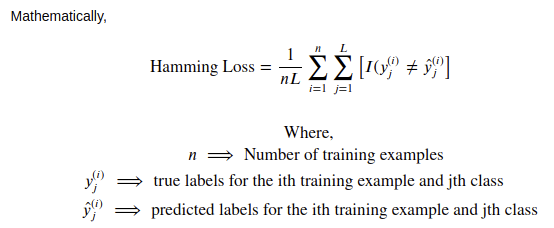

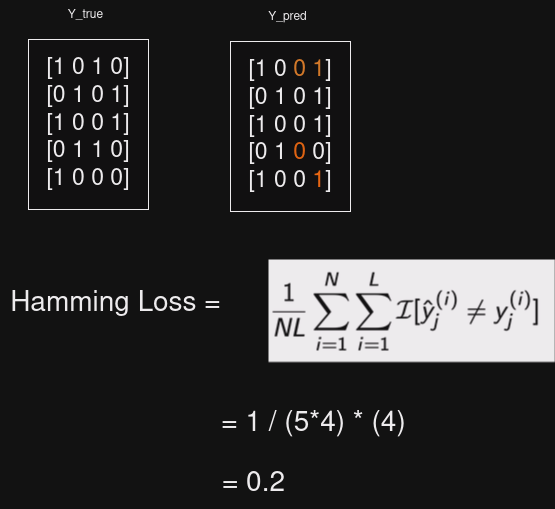

In [365]:
def hamming_loss(y_true, y_pred):
    y_pred = tf.cast(y_pred >= 0.5, "int32")
    y_true = tf.cast(y_true, "int32")
    
    hamming_ele_diff = tf.math.abs(y_true - y_pred)
    hamming_sum = tf.reduce_sum(hamming_ele_diff, axis=1) / y_true.shape[1]
    return tf.reduce_mean(hamming_sum).numpy()

In [366]:
dummy_y_true = tf.constant([[1., 0, 1, 0],
                            [0, 1, 0, 1],
                            [1, 0, 0, 1],
                            [0, 1, 1, 0],
                            [1, 0, 0, 0]])
dummy_y_pred = tf.constant([[1., 0, 0, 1],
                            [0, 1, 0, 1],
                            [1, 0, 0, 1],
                            [0, 1, 0, 0],
                            [1, 0, 0, 1]])

hamming_loss(dummy_y_true, dummy_y_pred)

0.2

## Subset Accuracy

- Subset Accuracy calculates the percentage of instances where the predicted set of labels exactly matches the true set of labels. It is strict and penalizes even one incorrect label in the predicted set.
- Suitable when the number of labels per instance is relatively small, and exact label matches are essential.

In [268]:
def subset_accuracy(y_true, y_pred):
    y_pred = tf.cast(y_pred >= 0.5, "int16")
    y_true = tf.cast(y_true, "int16")
    
    element_wise_equal = tf.reduce_all(tf.equal(y_true, y_pred), axis=1)
    # Count the number of samples with exact label matches
    correct_samples = tf.reduce_sum(tf.cast(element_wise_equal, tf.float32))
    # Calculate the total number of samples
    num_samples = tf.shape(y_true)[0]
    # Calculate the Subset Accuracy as the percentage of samples with exact label matches
    subset_accuracy_value = correct_samples / tf.cast(num_samples, tf.float32)
    return subset_accuracy_value.numpy()

In [369]:
subset_accuracy(dummy_y_true, dummy_y_pred)

0.4

Out of 5 exmaples, 2 are perfect match. Thus 2/5 == 0.4

# Train Function

In [371]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        loss = binary_cross_entropy(y_train, y_pred)
        

    dw, db = tape.gradient(loss, [model.weights, model.bias])
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss, {"accuracy":calculate_accuracy(y_train, y_pred), 
                  "hamming loss":hamming_loss(y_train, y_pred),
                  "subset_accuracy": subset_accuracy(y_train, y_pred)}

# Training Loop

In [372]:
def display_training_summary(loss, metrics, epoch, step):
    if step % 10 == 0:
        print(f"EPOCH: {epoch} STEP: {step} --- loss: {loss}---metrics: {metrics}")

In [373]:
#model initiate
model = MultiLabelLogisticRegression(len(LABELS))
LOSS_HISTORY = []

In [374]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    step = 0
    for batch in train_dataset.batch(64, drop_remainder=True):
        step += 1
        x, y = batch
        loss, metrics = train(model, x, y, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    display_training_summary(loss, metrics, epoch+1, step)

2023-07-25 10:02:16.306785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


build successfully


KeyboardInterrupt: 

As I have mentioned earlier, you can see the accuracy of the model.

# Testing

In [375]:
text = df_questions.iloc[1].Text
y_true_label = df_questions.iloc[1].Tags 

In [376]:
text

"forecasting demographic census what are some of the ways to forecast demographic census with some validation and calibration techniques some of the concerns census blocks vary in sizes as rural areas are a lot larger than condensed urban areas is there a need to account for the area size difference if let's say i have census data dating back to 4 5 census periods how far can i forecast it into the future if some of the census zone change lightly in boundaries how can i account for that change what are the methods to validate census forecasts for example if i have data for existing 5 census periods should i model the first 3 and test it on the latter two or is there another way what's the state of practice in forecasting census data and what are some of the state of the art methods"

In [377]:
y_true_label

array(['forecasting'], dtype=object)

In [388]:
y_true_label = multi_label_binarizer.transform([y_true_label])
y_true_label

TypeError: unhashable type: 'numpy.ndarray'

In [379]:
vector_rep = text_to_feature_vector([text]) / VOCAB_SIZE
vector_rep

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.038, 0.019, 0.063,
        0.005, 0.001, 0.846, 0.004, 0.569, 0.017, 0.063, 0.379, 0.009,
        0.949, 0.063, 0.005, 0.001, 0.01 , 0.821, 0.023, 0.019, 0.003,
        0.568, 0.822, 0.119, 0.007, 0.045, 0.003, 0.15 , 0.004, 0.635,
        0.011, 0.001, 0.725, 0.155, 0.173, 0.027, 0.505, 0.161, 0.002,
        0.018, 0.016, 0.9  , 0.004, 0.047, 0.042, 0.031, 0.443, 0.033,
        0.002, 0.569, 0.02 , 0.164, 0.001, 0.027, 0.063, 0.005, 0.001,
      

In [380]:
vector_rep.shape

(1, 180)

In [381]:
input_x = tf.constant(vector_rep)
input_x.shape

TensorShape([1, 180])

In [382]:
y_pred = model(input_x)

In [383]:
tf.math.round(tf.squeeze(y_pred))

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [384]:
calculate_accuracy(y_true_label, y_pred)

0.97

In [385]:
y_pred.shape

TensorShape([1, 100])

In [386]:
prediction_to_label(y_pred)

{'data-visualization': 0.8497869968414307,
 'bootstrap': 0.5509063005447388,
 'forecasting': 0.5400365591049194,
 'standard-error': 0.5027348399162292,
 'time-series': 0.4023827612400055,
 'anova': 0.28192374110221863,
 'distributions': 0.2585434913635254,
 'random-forest': 0.24220910668373108,
 'r': 0.1753731518983841,
 'classification': 0.13755418360233307,
 'hypothesis-testing': 0.13318228721618652,
 'proportion': 0.12474080920219421,
 'autocorrelation': 0.12390859425067902,
 'experiment-design': 0.12353238463401794,
 'cross-validation': 0.108017697930336,
 'model-selection': 0.10409758239984512,
 'poisson': 0.08813731372356415,
 'normal-distribution': 0.06832437962293625,
 'covariance': 0.06732535362243652,
 'binomial': 0.0639193132519722,
 'sample-size': 0.061847783625125885,
 'mean': 0.0519292913377285,
 'stata': 0.04686908423900604,
 'panel-data': 0.04351694509387016,
 'neural-networks': 0.03779326379299164,
 'survey': 0.03465742617845535,
 'missing-data': 0.03401844948530197,
 

# Compute class frequency

In [292]:
def compute_class_freq(one_hot_labels):
    total_num_rows = one_hot_labels.shape[0]
    pos_freq = tf.math.reduce_sum(one_hot_labels, axis=0)/total_num_rows
    neg_freq = 1 - pos_freq
    return pos_freq, neg_freq

In [293]:
dummy_labels = tf.math.round(tf.random.uniform([10, 5]))
dummy_labels

<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [1., 0., 1., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 1., 1., 1.],
       [1., 0., 1., 0., 0.],
       [0., 1., 1., 0., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 1., 1.]], dtype=float32)>

In [294]:
compute_classes_freq(dummy_labels)

(<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.5, 0.5, 0.9, 0.6, 0.7], dtype=float32)>,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.5       , 0.5       , 0.10000002, 0.39999998, 0.3       ],
       dtype=float32)>)

In [295]:
y.shape

TensorShape([64, 100])

In [296]:
pos_freq, neg_freq = compute_classes_freq(y)

In [297]:
pos_freq

<tf.Tensor: shape=(100,), dtype=float64, numpy=
array([0.015625, 0.03125 , 0.015625, 0.      , 0.0625  , 0.      ,
       0.015625, 0.015625, 0.      , 0.      , 0.03125 , 0.046875,
       0.015625, 0.      , 0.03125 , 0.078125, 0.015625, 0.      ,
       0.      , 0.      , 0.046875, 0.015625, 0.015625, 0.015625,
       0.015625, 0.      , 0.015625, 0.015625, 0.015625, 0.015625,
       0.      , 0.      , 0.      , 0.      , 0.0625  , 0.      ,
       0.      , 0.      , 0.      , 0.      , 0.03125 , 0.109375,
       0.      , 0.      , 0.      , 0.      , 0.03125 , 0.      ,
       0.015625, 0.015625, 0.      , 0.      , 0.      , 0.015625,
       0.      , 0.015625, 0.      , 0.03125 , 0.      , 0.015625,
       0.03125 , 0.0625  , 0.015625, 0.015625, 0.015625, 0.015625,
       0.      , 0.015625, 0.      , 0.015625, 0.03125 , 0.0625  ,
       0.015625, 0.      , 0.15625 , 0.      , 0.015625, 0.03125 ,
       0.03125 , 0.078125, 0.      , 0.015625, 0.      , 0.      ,
       0.01562

In [298]:
# Create a DataFrame for positive labels
data_pos = pd.DataFrame({"Class": LABELS, "Label": "Positive", "Value": pos_freq})

# Create a DataFrame for negative labels
data_neg = pd.DataFrame({"Class": LABELS, "Label": "Negative", "Value": neg_freq})

# Concatenate the two DataFrames vertically
data = pd.concat([data_pos, data_neg], ignore_index=True)

In [299]:
data.head()


,Class,Label,Value
0,algorithms,Positive,0.015625
1,anova,Positive,0.031250
2,arima,Positive,0.015625
3,autocorrelation,Positive,0.000000
4,bayesian,Positive,0.062500


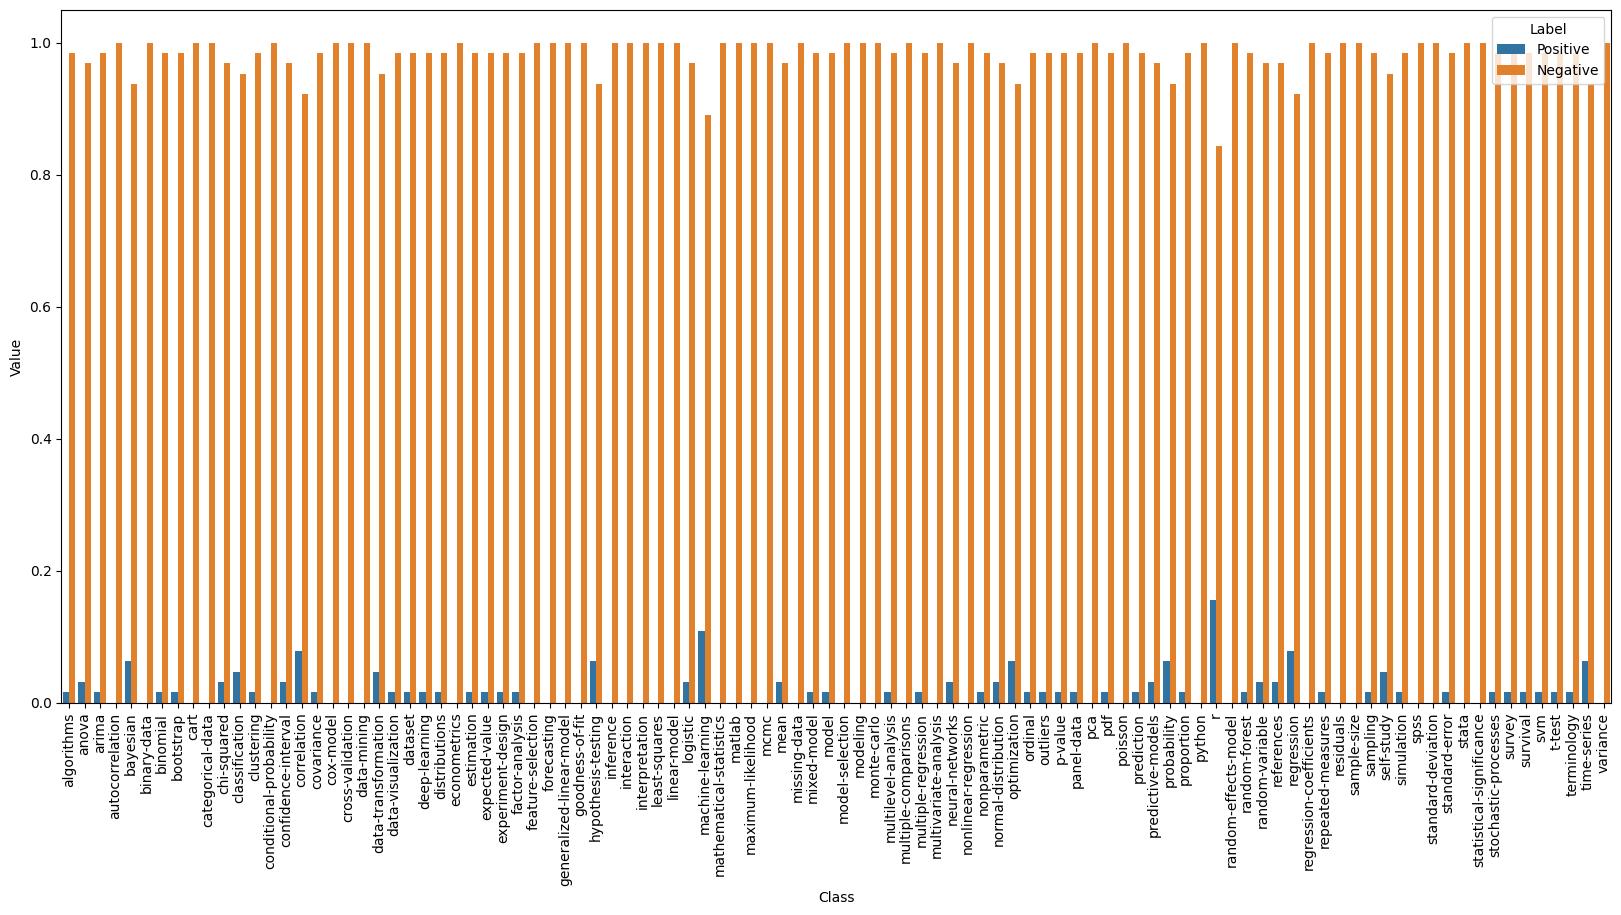

In [300]:
plt.figure(figsize=(20, 9))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

In [301]:
pos_weights = neg_freq
neg_weights = pos_freq
pos_contribution = pos_freq * pos_weights 
neg_contribution = neg_freq * neg_weights

In [302]:
pos_contribution == neg_contribution

<tf.Tensor: shape=(100,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])>

In [303]:
# Create a DataFrame for positive labels
data_pos = pd.DataFrame({"Class": LABELS, "Label": "Positive", "Value": pos_contribution})

# Create a DataFrame for negative labels
data_neg = pd.DataFrame({"Class": LABELS, "Label": "Negative", "Value": neg_contribution})

# Concatenate the two DataFrames vertically
data = pd.concat([data_pos, data_neg], ignore_index=True)

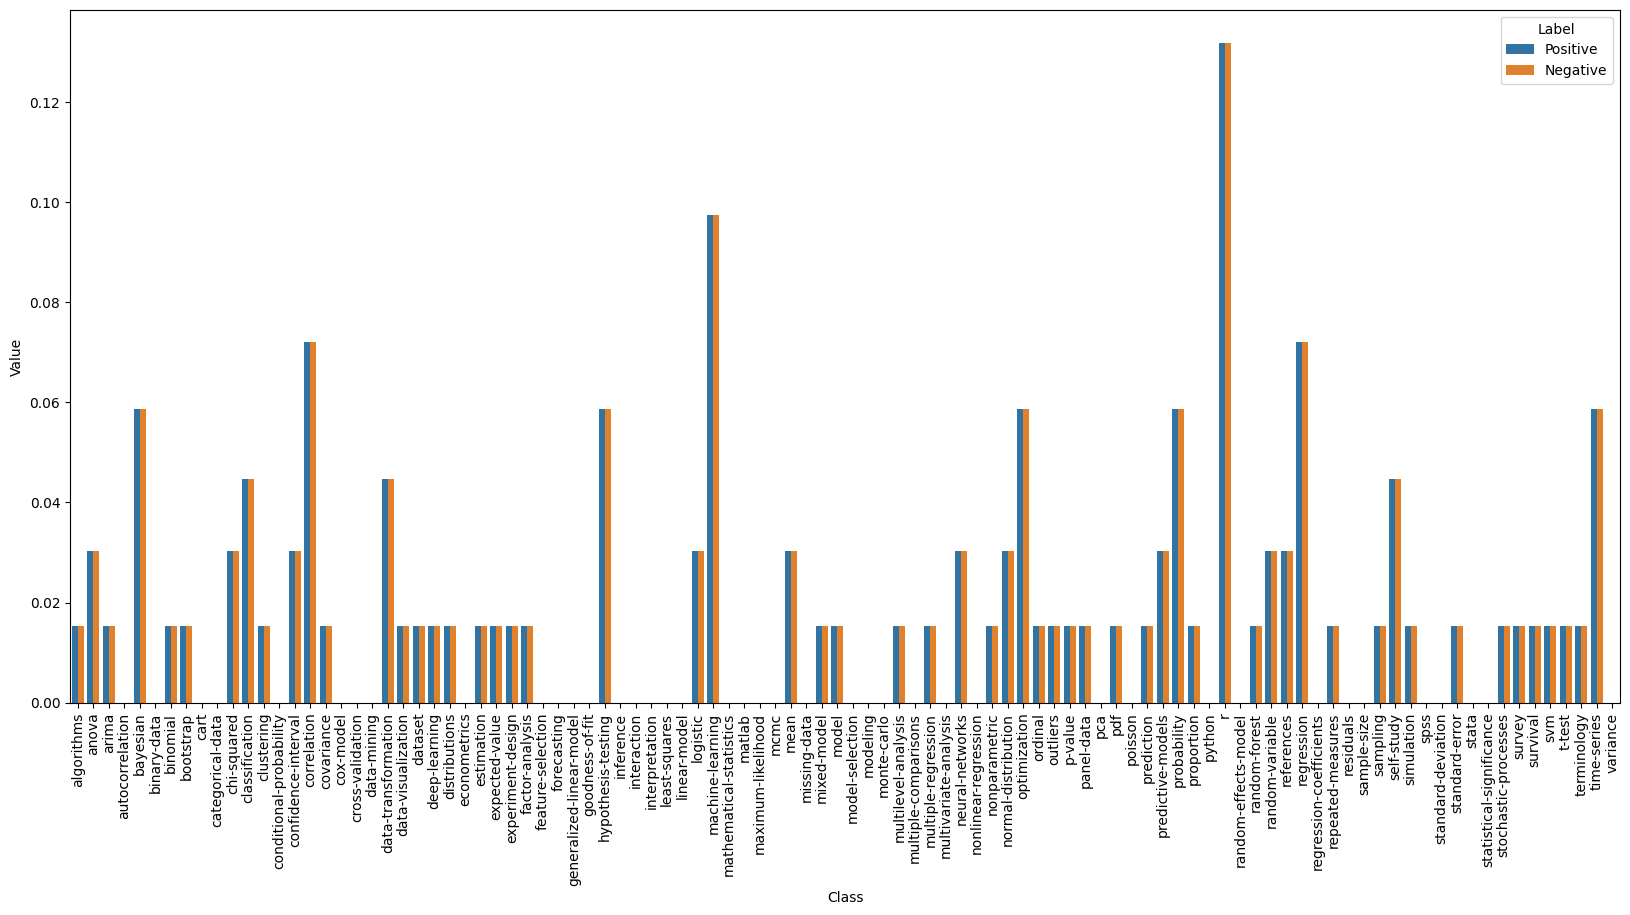

In [304]:
plt.figure(figsize=(20, 9))
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label", data=data)
plt.show()

# Weighted Loss function

In [305]:
def weighted_binary_cross_entropy(y_true, y_pred, pos_weights, neg_weights):
    y_true = tf.cast(tf.constant(y_true), "float32")
    y_pred = tf.cast(tf.constant(y_pred), "float32")
    pos_weights = tf.cast(pos_weights, "float32")
    neg_weights = tf.cast(neg_weights, "float32")
    """
    Return weighted loss value. 

    Args:
        y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
        y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
    Returns:
        loss (Float): overall scalar loss summed across all classes
    """
    # initialize loss to zero
    loss = 0.0
    epsilon = 1e-7  # A small value to prevent log(0) condition
    y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
    loss = pos_weights*y_true * tf.math.log(y_pred) + neg_weights*(1 - y_true)*tf.math.log(1-y_pred)
    sum_loss = tf.reduce_sum(loss, axis=1)
    return -tf.reduce_mean(sum_loss)

In [306]:
dummy_preds = tf.random.uniform([100, 10])
dummy_y_true = tf.math.round(tf.random.uniform([100, 10]))
dummy_y_true[:10]

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[1., 1., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 1., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1., 0., 0.],
       [1., 1., 1., 0., 1., 0., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 0., 1., 1., 0., 1.],
       [0., 0., 0., 1., 1., 0., 0., 0., 1., 0.],
       [1., 1., 1., 0., 1., 0., 1., 0., 1., 1.],
       [0., 1., 1., 0., 1., 0., 0., 1., 0., 0.]], dtype=float32)>

In [314]:
pos_freq, neg_freq = compute_classes_freq(dummy_y_true)
pos_weights = neg_freq
neg_weights = pos_freq

In [315]:
weighted_binary_cross_entropy(dummy_y_true, dummy_preds, pos_weights, neg_weights)

<tf.Tensor: shape=(), dtype=float32, numpy=4.880291>

In [316]:
weighted_binary_cross_entropy(dummy_y_true, dummy_y_true, pos_weights, neg_weights)

<tf.Tensor: shape=(), dtype=float32, numpy=5.926133e-07>

# Training

In [317]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        pos_freq, neg_freq = compute_classes_freq(y_pred)
        pos_weights = neg_freq
        neg_weights = pos_freq
        loss = weighted_binary_cross_entropy(y_train, y_pred, pos_weights, neg_weights)
        
    dw, db = tape.gradient(loss, [model.weights, model.bias])
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss, {"accuracy":calculate_accuracy(y_train, y_pred), 
                  "hamming loss":hamming_loss(y_train, y_pred),
                  "subset_accuracy": subset_accuracy(y_train, y_pred)}

In [318]:
# Training loop
#model initiate
model = MultiLabelLogisticRegression(len(LABELS))
LOSS_HISTORY = []

In [319]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    step = 0
    for batch in train_dataset.batch(64, drop_remainder=True):
        step += 1
        x, y = batch
        loss, metrics = train(model, x, y, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    display_training_summary(loss, metrics, epoch+1, step)

2023-07-24 23:16:56.693127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


build successfully
EPOCH: 1 STEP: 930 --- loss: 7.083852291107178---metrics: {'accuracy': 0.9425, 'hamming loss': 0.057499997, 'subset_accuracy': 0.0}


2023-07-24 23:17:03.644180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 2 STEP: 930 --- loss: 6.826591491699219---metrics: {'accuracy': 0.94640625, 'hamming loss': 0.053593747, 'subset_accuracy': 0.0}


2023-07-24 23:17:10.502832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 3 STEP: 930 --- loss: 6.613139629364014---metrics: {'accuracy': 0.9484375, 'hamming loss': 0.0515625, 'subset_accuracy': 0.0}


2023-07-24 23:17:17.364493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 4 STEP: 930 --- loss: 6.430078506469727---metrics: {'accuracy': 0.95125, 'hamming loss': 0.04875, 'subset_accuracy': 0.0}


2023-07-24 23:17:24.203193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 5 STEP: 930 --- loss: 6.269024848937988---metrics: {'accuracy': 0.9532812, 'hamming loss': 0.046718746, 'subset_accuracy': 0.0}


2023-07-24 23:17:30.868414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 6 STEP: 930 --- loss: 6.125478744506836---metrics: {'accuracy': 0.9554688, 'hamming loss': 0.04453125, 'subset_accuracy': 0.0}


2023-07-24 23:17:37.722695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 7 STEP: 930 --- loss: 5.996505260467529---metrics: {'accuracy': 0.95703125, 'hamming loss': 0.04296875, 'subset_accuracy': 0.0}


2023-07-24 23:17:44.471747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 8 STEP: 930 --- loss: 5.879890441894531---metrics: {'accuracy': 0.9596875, 'hamming loss': 0.0403125, 'subset_accuracy': 0.015625}


2023-07-24 23:17:51.902485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 9 STEP: 930 --- loss: 5.77382755279541---metrics: {'accuracy': 0.960625, 'hamming loss': 0.039375, 'subset_accuracy': 0.015625}


2023-07-24 23:17:59.448846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 10 STEP: 930 --- loss: 5.677017688751221---metrics: {'accuracy': 0.96171874, 'hamming loss': 0.038281247, 'subset_accuracy': 0.015625}


2023-07-24 23:18:06.921187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 11 STEP: 930 --- loss: 5.588269233703613---metrics: {'accuracy': 0.961875, 'hamming loss': 0.038125, 'subset_accuracy': 0.015625}


2023-07-24 23:18:14.127743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 12 STEP: 930 --- loss: 5.506598472595215---metrics: {'accuracy': 0.9634375, 'hamming loss': 0.036562502, 'subset_accuracy': 0.015625}


2023-07-24 23:18:21.493333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 13 STEP: 930 --- loss: 5.431183815002441---metrics: {'accuracy': 0.9646875, 'hamming loss': 0.0353125, 'subset_accuracy': 0.015625}


2023-07-24 23:18:28.925460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 14 STEP: 930 --- loss: 5.361331939697266---metrics: {'accuracy': 0.96546876, 'hamming loss': 0.03453125, 'subset_accuracy': 0.015625}


2023-07-24 23:18:35.789461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 15 STEP: 930 --- loss: 5.29646110534668---metrics: {'accuracy': 0.9659375, 'hamming loss': 0.034062497, 'subset_accuracy': 0.015625}


2023-07-24 23:18:42.964473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 16 STEP: 930 --- loss: 5.236075401306152---metrics: {'accuracy': 0.96703124, 'hamming loss': 0.032968752, 'subset_accuracy': 0.015625}


2023-07-24 23:18:50.298817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 17 STEP: 930 --- loss: 5.179746627807617---metrics: {'accuracy': 0.9675, 'hamming loss': 0.0325, 'subset_accuracy': 0.015625}


2023-07-24 23:18:57.525470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 18 STEP: 930 --- loss: 5.127108573913574---metrics: {'accuracy': 0.968125, 'hamming loss': 0.031875, 'subset_accuracy': 0.015625}


2023-07-24 23:19:04.646806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 19 STEP: 930 --- loss: 5.0778374671936035---metrics: {'accuracy': 0.96875, 'hamming loss': 0.031249998, 'subset_accuracy': 0.015625}


2023-07-24 23:19:11.200282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 20 STEP: 930 --- loss: 5.031648635864258---metrics: {'accuracy': 0.9690625, 'hamming loss': 0.030937498, 'subset_accuracy': 0.015625}


2023-07-24 23:19:17.759251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 21 STEP: 930 --- loss: 4.988290786743164---metrics: {'accuracy': 0.97, 'hamming loss': 0.03, 'subset_accuracy': 0.015625}


2023-07-24 23:19:24.340758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 22 STEP: 930 --- loss: 4.94753885269165---metrics: {'accuracy': 0.970625, 'hamming loss': 0.029375, 'subset_accuracy': 0.015625}


2023-07-24 23:19:30.883207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 23 STEP: 930 --- loss: 4.909189224243164---metrics: {'accuracy': 0.971875, 'hamming loss': 0.028125, 'subset_accuracy': 0.03125}


2023-07-24 23:19:37.433741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 24 STEP: 930 --- loss: 4.8730597496032715---metrics: {'accuracy': 0.9721875, 'hamming loss': 0.0278125, 'subset_accuracy': 0.046875}


2023-07-24 23:19:44.050087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 25 STEP: 930 --- loss: 4.838985443115234---metrics: {'accuracy': 0.9728125, 'hamming loss': 0.0271875, 'subset_accuracy': 0.046875}


2023-07-24 23:19:50.619251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 26 STEP: 930 --- loss: 4.806816101074219---metrics: {'accuracy': 0.9734375, 'hamming loss': 0.026562499, 'subset_accuracy': 0.046875}


2023-07-24 23:19:57.471632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 27 STEP: 930 --- loss: 4.776414394378662---metrics: {'accuracy': 0.974375, 'hamming loss': 0.025625, 'subset_accuracy': 0.046875}


2023-07-24 23:20:04.391840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 28 STEP: 930 --- loss: 4.747656345367432---metrics: {'accuracy': 0.97515625, 'hamming loss': 0.024843749, 'subset_accuracy': 0.046875}


2023-07-24 23:20:10.927926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 29 STEP: 930 --- loss: 4.720428466796875---metrics: {'accuracy': 0.97546875, 'hamming loss': 0.024531249, 'subset_accuracy': 0.046875}


2023-07-24 23:20:17.553227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 30 STEP: 930 --- loss: 4.6946258544921875---metrics: {'accuracy': 0.975625, 'hamming loss': 0.024375, 'subset_accuracy': 0.046875}


2023-07-24 23:20:24.151167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 31 STEP: 930 --- loss: 4.670154571533203---metrics: {'accuracy': 0.97609377, 'hamming loss': 0.02390625, 'subset_accuracy': 0.046875}


2023-07-24 23:20:30.709074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 32 STEP: 930 --- loss: 4.646925926208496---metrics: {'accuracy': 0.9765625, 'hamming loss': 0.0234375, 'subset_accuracy': 0.046875}


2023-07-24 23:20:37.281245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 33 STEP: 930 --- loss: 4.624860763549805---metrics: {'accuracy': 0.976875, 'hamming loss': 0.023124998, 'subset_accuracy': 0.046875}


2023-07-24 23:20:43.840789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 34 STEP: 930 --- loss: 4.603883743286133---metrics: {'accuracy': 0.976875, 'hamming loss': 0.023124998, 'subset_accuracy': 0.046875}


2023-07-24 23:20:50.772845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 35 STEP: 930 --- loss: 4.583927631378174---metrics: {'accuracy': 0.97703123, 'hamming loss': 0.022968749, 'subset_accuracy': 0.046875}


2023-07-24 23:20:57.498293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 36 STEP: 930 --- loss: 4.564929485321045---metrics: {'accuracy': 0.97765625, 'hamming loss': 0.02234375, 'subset_accuracy': 0.0625}


2023-07-24 23:21:04.442473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 37 STEP: 930 --- loss: 4.546831130981445---metrics: {'accuracy': 0.97796875, 'hamming loss': 0.02203125, 'subset_accuracy': 0.0625}


2023-07-24 23:21:10.975054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 38 STEP: 930 --- loss: 4.5295796394348145---metrics: {'accuracy': 0.978125, 'hamming loss': 0.021875, 'subset_accuracy': 0.0625}


2023-07-24 23:21:17.653135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 39 STEP: 930 --- loss: 4.513124465942383---metrics: {'accuracy': 0.97828126, 'hamming loss': 0.02171875, 'subset_accuracy': 0.0625}


2023-07-24 23:21:24.257361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 40 STEP: 930 --- loss: 4.497419357299805---metrics: {'accuracy': 0.9784375, 'hamming loss': 0.0215625, 'subset_accuracy': 0.0625}


2023-07-24 23:21:30.815751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 41 STEP: 930 --- loss: 4.482422351837158---metrics: {'accuracy': 0.97875, 'hamming loss': 0.021249998, 'subset_accuracy': 0.0625}


2023-07-24 23:21:37.843450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 42 STEP: 930 --- loss: 4.468093395233154---metrics: {'accuracy': 0.9789063, 'hamming loss': 0.021093749, 'subset_accuracy': 0.0625}


2023-07-24 23:21:45.497166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 43 STEP: 930 --- loss: 4.454395294189453---metrics: {'accuracy': 0.9795312, 'hamming loss': 0.02046875, 'subset_accuracy': 0.0625}


2023-07-24 23:21:52.461489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 44 STEP: 930 --- loss: 4.441293716430664---metrics: {'accuracy': 0.9796875, 'hamming loss': 0.0203125, 'subset_accuracy': 0.0625}


2023-07-24 23:21:59.084059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 45 STEP: 930 --- loss: 4.4287567138671875---metrics: {'accuracy': 0.97984374, 'hamming loss': 0.02015625, 'subset_accuracy': 0.0625}


2023-07-24 23:22:06.104542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 46 STEP: 930 --- loss: 4.416753768920898---metrics: {'accuracy': 0.98, 'hamming loss': 0.02, 'subset_accuracy': 0.0625}


2023-07-24 23:22:12.644457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 47 STEP: 930 --- loss: 4.405257225036621---metrics: {'accuracy': 0.98015624, 'hamming loss': 0.01984375, 'subset_accuracy': 0.0625}


2023-07-24 23:22:19.333937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 48 STEP: 930 --- loss: 4.394240856170654---metrics: {'accuracy': 0.98015624, 'hamming loss': 0.01984375, 'subset_accuracy': 0.0625}


2023-07-24 23:22:26.642705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 49 STEP: 930 --- loss: 4.38368034362793---metrics: {'accuracy': 0.98015624, 'hamming loss': 0.01984375, 'subset_accuracy': 0.0625}


2023-07-24 23:22:33.969599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 50 STEP: 930 --- loss: 4.373551845550537---metrics: {'accuracy': 0.98015624, 'hamming loss': 0.01984375, 'subset_accuracy': 0.0625}


2023-07-24 23:22:41.493619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 51 STEP: 930 --- loss: 4.363833904266357---metrics: {'accuracy': 0.9803125, 'hamming loss': 0.0196875, 'subset_accuracy': 0.0625}


2023-07-24 23:22:48.903747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 52 STEP: 930 --- loss: 4.3545074462890625---metrics: {'accuracy': 0.9803125, 'hamming loss': 0.0196875, 'subset_accuracy': 0.0625}


2023-07-24 23:22:56.109017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 53 STEP: 930 --- loss: 4.345551490783691---metrics: {'accuracy': 0.9803125, 'hamming loss': 0.0196875, 'subset_accuracy': 0.0625}


2023-07-24 23:23:03.371822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 54 STEP: 930 --- loss: 4.336949348449707---metrics: {'accuracy': 0.9803125, 'hamming loss': 0.0196875, 'subset_accuracy': 0.0625}


2023-07-24 23:23:10.533494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 55 STEP: 930 --- loss: 4.328683376312256---metrics: {'accuracy': 0.980625, 'hamming loss': 0.019375, 'subset_accuracy': 0.0625}


2023-07-24 23:23:17.761665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 56 STEP: 930 --- loss: 4.320737838745117---metrics: {'accuracy': 0.98078126, 'hamming loss': 0.01921875, 'subset_accuracy': 0.078125}


2023-07-24 23:23:24.995253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 57 STEP: 930 --- loss: 4.313097953796387---metrics: {'accuracy': 0.98078126, 'hamming loss': 0.01921875, 'subset_accuracy': 0.078125}


2023-07-24 23:23:32.373783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 58 STEP: 930 --- loss: 4.30574893951416---metrics: {'accuracy': 0.9809375, 'hamming loss': 0.0190625, 'subset_accuracy': 0.078125}


2023-07-24 23:23:39.825998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 59 STEP: 930 --- loss: 4.298677444458008---metrics: {'accuracy': 0.98109376, 'hamming loss': 0.01890625, 'subset_accuracy': 0.078125}


2023-07-24 23:23:47.053642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 60 STEP: 930 --- loss: 4.291872024536133---metrics: {'accuracy': 0.98125, 'hamming loss': 0.018749999, 'subset_accuracy': 0.078125}


2023-07-24 23:23:54.184688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 61 STEP: 930 --- loss: 4.285318374633789---metrics: {'accuracy': 0.9815625, 'hamming loss': 0.0184375, 'subset_accuracy': 0.078125}


2023-07-24 23:24:01.516954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 62 STEP: 930 --- loss: 4.279007434844971---metrics: {'accuracy': 0.9815625, 'hamming loss': 0.0184375, 'subset_accuracy': 0.078125}


2023-07-24 23:24:08.367188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 63 STEP: 930 --- loss: 4.272927284240723---metrics: {'accuracy': 0.9817188, 'hamming loss': 0.01828125, 'subset_accuracy': 0.078125}


2023-07-24 23:24:15.267542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 64 STEP: 930 --- loss: 4.267067909240723---metrics: {'accuracy': 0.9817188, 'hamming loss': 0.01828125, 'subset_accuracy': 0.078125}


2023-07-24 23:24:22.634809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 65 STEP: 930 --- loss: 4.261419773101807---metrics: {'accuracy': 0.9817188, 'hamming loss': 0.01828125, 'subset_accuracy': 0.078125}


2023-07-24 23:24:30.006363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 66 STEP: 930 --- loss: 4.2559733390808105---metrics: {'accuracy': 0.9817188, 'hamming loss': 0.01828125, 'subset_accuracy': 0.078125}


2023-07-24 23:24:37.245228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 67 STEP: 930 --- loss: 4.250720500946045---metrics: {'accuracy': 0.9815625, 'hamming loss': 0.0184375, 'subset_accuracy': 0.0625}


2023-07-24 23:24:44.898577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 68 STEP: 930 --- loss: 4.24565315246582---metrics: {'accuracy': 0.9815625, 'hamming loss': 0.0184375, 'subset_accuracy': 0.0625}


2023-07-24 23:24:52.580829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 69 STEP: 930 --- loss: 4.240762233734131---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:00.238873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 70 STEP: 930 --- loss: 4.236042022705078---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:07.852210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 71 STEP: 930 --- loss: 4.231484413146973---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:15.655366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 72 STEP: 930 --- loss: 4.227082252502441---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:22.898275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 73 STEP: 930 --- loss: 4.222829818725586---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:30.595136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 74 STEP: 930 --- loss: 4.218721866607666---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:37.899728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 75 STEP: 930 --- loss: 4.21475076675415---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:45.650887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 76 STEP: 930 --- loss: 4.210911750793457---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:25:52.956782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 77 STEP: 930 --- loss: 4.20720100402832---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:00.268277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 78 STEP: 930 --- loss: 4.203610897064209---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:08.110500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 79 STEP: 930 --- loss: 4.200139045715332---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:15.339472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 80 STEP: 930 --- loss: 4.196779251098633---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:23.328542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 81 STEP: 930 --- loss: 4.1935272216796875---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:30.488286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 82 STEP: 930 --- loss: 4.190380096435547---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:37.169243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 83 STEP: 930 --- loss: 4.187332630157471---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:43.762510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 84 STEP: 930 --- loss: 4.184381008148193---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:50.886737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 85 STEP: 930 --- loss: 4.181522369384766---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:26:57.662963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 86 STEP: 930 --- loss: 4.178752899169922---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:04.263537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 87 STEP: 930 --- loss: 4.176069736480713---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:11.105522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 88 STEP: 930 --- loss: 4.173468589782715---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:18.083446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 89 STEP: 930 --- loss: 4.170947074890137---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:25.054964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 90 STEP: 930 --- loss: 4.168501853942871---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:31.734086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 91 STEP: 930 --- loss: 4.166131019592285---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:39.142170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 92 STEP: 930 --- loss: 4.1638312339782715---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:46.675299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 93 STEP: 930 --- loss: 4.161600589752197---metrics: {'accuracy': 0.981875, 'hamming loss': 0.018125, 'subset_accuracy': 0.0625}


2023-07-24 23:27:53.913207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 94 STEP: 930 --- loss: 4.159435272216797---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}


2023-07-24 23:28:01.076600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 95 STEP: 930 --- loss: 4.157334327697754---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}


2023-07-24 23:28:08.379581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 96 STEP: 930 --- loss: 4.155294418334961---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}


2023-07-24 23:28:15.160341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 97 STEP: 930 --- loss: 4.153314590454102---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}


2023-07-24 23:28:21.816845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 98 STEP: 930 --- loss: 4.151391983032227---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}


2023-07-24 23:28:28.453698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 99 STEP: 930 --- loss: 4.149524688720703---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}


2023-07-24 23:28:35.297265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [59559,100]
	 [[{{node Placeholder/_1}}]]


EPOCH: 100 STEP: 930 --- loss: 4.147710800170898---metrics: {'accuracy': 0.9820312, 'hamming loss': 0.01796875, 'subset_accuracy': 0.0625}
